# Reading the ROOT files

In [34]:
exec(open("./do_imports.py").read())

2.3.0 /home/sophiafarrell/.local/lib/python3.7/site-packages/tensorflow/__init__.py


In [3]:
import seaborn as sns

In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [5]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

We want where quicknext<500 us (so another prompt follows) and the subid==1. 

What if we boost our fast-neutron stamps by not requiring it to be the first event (so tri-neutron events recorded too but in pairs?) 
<br>
Obviously this is not realistic since we'd veto these by having 3, but we can at least pretend they're di-neutrons! 

Edit: the next code is already doing that! We gain 1149/5500 of the stats from that trick, which is necessary. 

In [6]:
def get_paired_data(data):
    next_ts = data.timestamp[1:]
    next_ts = ak.concatenate([next_ts, 0])

    condition_1 = next_ts - data.timestamp<600
    condition_2 = next_ts - data.timestamp>0
    condition_3 = data.dt_next_us < 600

    both = condition_1 * condition_2 * condition_3

    first_of_two = ak.where(both)[0]
    signal1 = data[first_of_two]
    signal2 = data[first_of_two+1]
    
    return signal1, signal2

In [33]:
fn0, fn1 = get_paired_data(fastn)
ibd0, ibd1 = get_paired_data(ibd)

### Prep data for model input

In [11]:
selection = [ibd0, fn0]
samples = min([len(i) for i in selection])
# smth = [i[:samples] for i in selection]

npmts = 2330
timetot = 1500 #ns 
tres = 10 # ns 
div_factor = tres 
nbins = int(timetot/tres)


In [12]:
size = samples * len(selection)
y = np.array([]) 

first = np.zeros((size, npmts, nbins), dtype=np.float32)
second = np.zeros_like(first)

data_to_manipulate = [[fn0, fn1], [ibd0, ibd1]]
for d, (signal1, signal2) in enumerate(data_to_manipulate):
    print('set %i of %i'%(d+1, len(data_to_manipulate)))
    
    new_bins1 = ak.values_astype((signal1.hittime-300)/div_factor, np.int32)
    new_bins2 = ak.values_astype((signal2.hittime-300)/div_factor, np.int32)

    for i in range(0, samples):
        first[(d+1)*i, signal1.channel[i], new_bins1[i]]=signal1.pmtcharge[i]
        second[(d+1)*i, signal2.channel[i], new_bins2[i]]=signal2.pmtcharge[i]
    y=np.append(y, d*np.ones(samples))


set 1 of 2
set 2 of 2


In [13]:
X_train1, X_test1, X_train2, X_test2, y_train, y_test = train_test_split(
    first, second, y,
    test_size=0.25, random_state=43
)

In [14]:
del first, second, data_to_manipulate, new_bins1, new_bins2, fn0, fn1, ibd0, ibd1
gc.collect()

390

------

Separate out prompt/delayed IBD and delta-ray/neutron capture fast-neutrons

In [36]:
from tensorflow.keras import layers

In [37]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        num_nodes = tf.math.reduce_max(node_indices) + 1
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(node_indices, neighbour_messages)
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

In [38]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.squeeze(tf.gather(x, input_node_indices))
        # Compute logits
        return self.compute_logits(node_embeddings)

In [ ]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

In [39]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

NameError: name 'graph_info' is not defined

## Getting data in input form

Need to get those with a 1 for sure as it has a 0, then take those separated by the 0 or 1 

In [15]:
model = load_model('weights/coupled_crnn_2.h5')

In [16]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2330, 150)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2330, 150)]  0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 2330, 128)    142848      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 2330, 128)    142848      input_2[0][0]                    
_______________________________________________________________________________________

In [17]:
scores = model.predict([X_test1, X_test2], verbose=1)
rnn_out_test = scores

89/89 [==============================] - 25s 282ms/step


In [18]:
rnn_out_train = model.predict([X_train1, X_train2], verbose=1)

267/267 [==============================] - 80s 300ms/step


In [19]:
if scores.shape[1]>1:
    y_pred_2 = np.argmax(scores, axis=1)
    y_test_2 = np.argmax(y_test, axis=1)
else:
    y_pred_2, y_test_2 = np.round(scores), y_test

In [20]:
def draw_confmat(classes=3, 
                 y_test_2=y_test_2, 
                 y_pred_2=y_pred_2, 
                 scores=scores):
    confmat = confusion_matrix(y_test_2, y_pred_2)
    plt.figure(figsize=(6,4))
    ax = sns.heatmap(confmat, annot=True, fmt='g', 
                    )

    ax.set_title('Confusion Matrix fast-n vs. ibd')
    ax.set_xlabel('Predicted PID')
    ax.set_ylabel('Actual PID')

    if classes==2: labels = ['fastn', 'ibd']
    elif classes==3: labels=['fastn', 'ibd0', 'ibd1']
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

    plt.show()
    
def draw_roc(classes=3, y_test_2=y_test_2, scores=scores):
    if classes==3: 
        cat1 = [0, 0, 1]
        cat2 = [1, 2, 2]
        labels = ['fastn/ibd0', 'fastn/ibd1', 'ibd0/ibd1',]
    elif classes==2:
        cat1 = [0]
        cat2 = [1]
        labels = ['fast-n/ibd']
        
    plt.figure(figsize=(6,4))
    for i, j, label in zip(cat1, cat2, 
                            labels,
                             ):
        mask = [any(t) for t in zip(y_test_2==i, y_test_2==j)]
        
        if scores.shape[1]>1: prob = scores[:, j][mask]
        else: prob = scores[mask]
        guesses = y_test_2[mask]
        guesses = guesses - np.min(guesses)
        guesses = guesses/np.max(guesses)

        fpr, tpr, thresholds = roc_curve(guesses, prob)

        auc = roc_auc_score(y_test_2[mask], prob)
        plt.plot(fpr, tpr, 
             label='%s (AUC = %0.3f)'%(label, auc), 
    #          color='darkorange', 
             lw=2, 
            )
    plt.xlim([-0.01, 1.0])
    plt.ylim([0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('RNN ROC: Fast-neutron vs. ibd')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.legend()
    plt.grid()
    plt.show()    

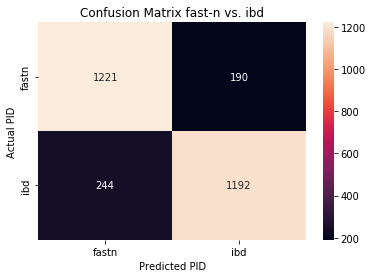

In [21]:
draw_confmat(classes=2)

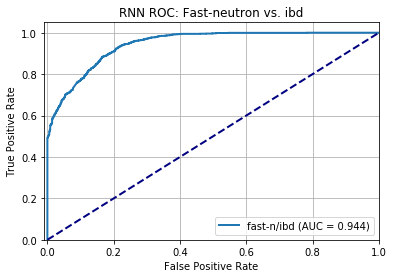

In [22]:
draw_roc(classes=2)

In [23]:
del model
gc.collect()

8359

## Take RNN output and add to X1 (RF) data

In [81]:
dimensions = [
    'n9', 'n100', 
#     'x', 'y', 'z', 
#     'r',
    'id_plus_dr_hit', 
    'good_dir', 
#     'good_dir_next', 
    'good_pos',
#     'good_pos_next', 
#     'distpmt', 
    'closestPMT', 'closestPMT_next', 
    'drNextr', # 'dzNextz', 
     'dt_next_us', 
#     'azimuth_ks', 
#     'azimuth_ks_next',
#     'n100_next','n9_next',
    'pe', 
    'beta_one', 
#     'beta_one', 'beta_two', 'beta_three', 'beta_four', 'beta_five', 'beta_six',
#     'beta_one_prev', 'beta_two_prev', 'beta_three_prev', 'beta_four_prev', 'beta_five_prev', 'beta_six_prev',
]
def get_dims(data, dimensions=dimensions):
    df_cut = data[dimensions]
    print('Remaining variables selected for analysis: %i'%(len(dimensions)))
    return df_cut

In [82]:
data_to_manipulate = [fn0, ibd0]
samples = min([len(i) for i in data_to_manipulate])

x1 = data_to_manipulate[0][:samples]
x1 = ak.concatenate((x1, data_to_manipulate[1][:samples]))

X1 = get_dims(x1, dimensions=dimensions)
X1 = ak.to_pandas(X1)

X_train3, X_test3, y_train, y_test= train_test_split(X1, y, test_size=0.25, random_state=43) 
X_save = X_test3
sc = StandardScaler()
X_train3 = sc.fit_transform(X_train3)
X_test3 = sc.transform(X_test3)

Remaining variables selected for analysis: 11


In [83]:
# rnn_out_train = np.zeros((len(y_train),1))
# rnn_out_test = np.zeros((len(y_test),1))

In [84]:
def rnn_to_rf(classes=3, y_train=y_train, y_test=y_test):
    if classes==2: 
        yy_train, yy_test = y_train, y_test
    if classes>2:
        yy_train = np.argmax(y_train, axis=1)
        yy_test = np.argmax(y_test, axis=1)

    new_train = np.hstack((X_train3, rnn_out_train))
    new_test = np.hstack((X_test3, rnn_out_test))
    
    return new_train, new_test, yy_train, yy_test

In [85]:
classes=2
if classes==2: newdims = ['rnn_out']
elif classes==3: newdims = ['rnn_out_fn', 'rnn_out_ibd0', 'rnn_out_ibd1']

dims_add = dimensions.copy()
for i in newdims:
    dims_add.append(i)

In [86]:
new_train, new_test, yy_train, yy_test = rnn_to_rf(classes=2)

In [87]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(
    n_estimators=100, 
    max_depth=12, 
#     min_samples_leaf=2,
    bootstrap=True,
)
#Train the model using the training sets
clf.fit(new_train,yy_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [88]:
y_train_pred = clf.predict(new_train)
y_test_pred=clf.predict(new_test)

In [89]:
# Model Accuracy, how often is the classifier correct?
print("Train Accuracy: %.2f%%"%(metrics.accuracy_score(yy_train, y_train_pred)*100))
print("Test Accuracy: %.2f%%"%(metrics.accuracy_score(yy_test, y_test_pred)*100))

Train Accuracy: 99.12%
Test Accuracy: 94.17%


In [56]:
feature_imp = pd.Series(clf.feature_importances_,index=dims_add).sort_values(ascending=False)

In [57]:
scores = clf.predict_proba(new_test)

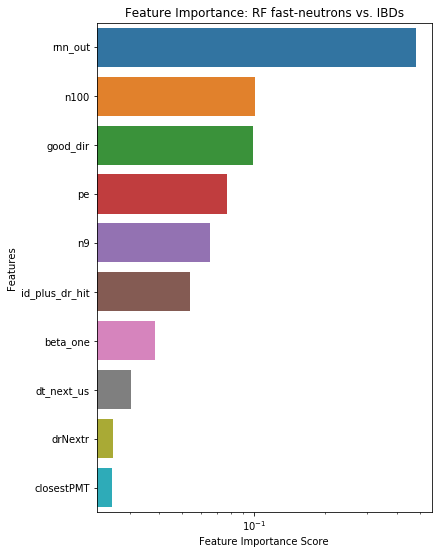

In [58]:
# Creating a bar plot
plt.figure(figsize=(6, 9))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.xscale('log')
plt.ylabel('Features')
plt.title("Feature Importance: RF fast-neutrons vs. IBDs")
# plt.legend()
plt.show()

In [59]:
def draw_confmat(classes=3, 
                 y_test_2=yy_test, 
                 y_pred_2=y_test_pred, 
                 scores=scores,
                **kwargs):
    confmat = confusion_matrix(y_test_2, y_pred_2)
    plt.figure(figsize=(6,4))
    ax = sns.heatmap(confmat, annot=True, fmt='g', 
                    )

    ax.set_title('Confusion Matrix fast-n vs. ibd')
    ax.set_xlabel('Predicted PID')
    ax.set_ylabel('Actual PID')

    if classes==2: labels = ['fastn', 'ibd']
    elif classes==3: labels=['fastn', 'ibd0', 'ibd1']
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

    plt.show()
    
def draw_roc(classes=3, y_test_2=yy_test, scores=scores):
    if classes==3: 
        cat1 = [0, 0, 1]
        cat2 = [1, 2, 2]
        labels = ['fastn/ibd0', 'fastn/ibd1', 'ibd0/ibd1',]
    elif classes==2:
        cat1 = [0]
        cat2 = [1]
        labels = ['fast-n/ibd']
        
    plt.figure(figsize=(6,4))
    for i, j, label in zip(cat1, cat2, 
                            labels,
                             ):
        mask = [any(t) for t in zip(y_test_2==i, y_test_2==j)]
        
        if scores.shape[1]>1: prob = scores[:, j][mask]
        else: prob = scores[mask]
        guesses = y_test_2[mask]
        guesses = guesses - np.min(guesses)
        guesses = guesses/np.max(guesses)

        fpr, tpr, thresholds = roc_curve(guesses, prob)

        auc = roc_auc_score(y_test_2[mask], prob)
        plt.plot(fpr, tpr, 
             label='%s (AUC = %0.3f)'%(label, auc), 
    #          color='darkorange', 
             lw=2, 
            )
    plt.xlim([-0.01, 1.0])
    plt.ylim([0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('NN into RF ROC: fast-n vs. ibd')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.legend()
    plt.grid()
    plt.show()    

In [60]:
if scores.shape[1]>1:
    y_pred_2 = np.argmax(scores, axis=1)
    try: y_test_2 = np.argmax(y_test, axis=1)
    except: y_test_2=y_test
else:
    y_pred_2, y_test_2 = np.round(scores), y_test

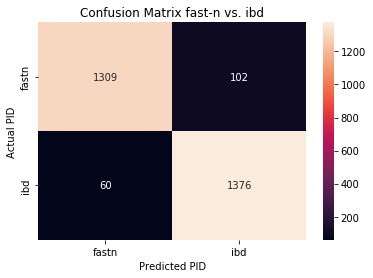

In [61]:
draw_confmat(classes=2, y_test_2=y_test_2, y_pred_2=y_pred_2)

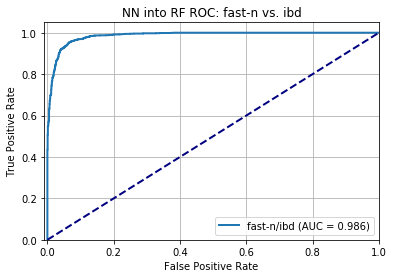

In [62]:
draw_roc(2, yy_test, scores)

In [41]:
preds = y_pred_2.reshape(len(y_pred_2))
error_inds = np.argwhere(y_test_2!=preds)
error_inds = error_inds.reshape(len(error_inds))

In [42]:
true_label = y_test_2[error_inds]

In [43]:
wrong_data = X_save.iloc[error_inds]
wrongibd = wrong_data[true_label==1]
wrongfn = wrong_data[true_label==0]

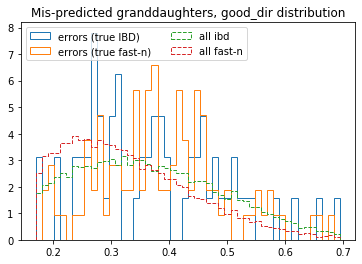

In [46]:
kw = dict(histtype='step', density=True)
key = 'good_dir'
bins= plt.hist(wrongibd[key], bins=50, label='errors (true IBD)', **kw)
plt.hist(wrongfn[key], bins=bins[1], label='errors (true fast-n)', **kw)
plt.hist(ibd[key], bins=bins[1], label='all ibd', linestyle='--', **kw)
plt.hist(fastn[key], bins=bins[1], label='all fast-n', linestyle='--', **kw)

plt.title('Mis-predicted granddaughters, %s distribution'%(key))
plt.legend(loc='upper left', ncol=2)
plt.show()